# PokeGAN

Simple GAN trained on all the pokemon sprite images. No transfer learning is used and the only input to the generator is the random vector.

In [35]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(".")))

In [338]:
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from src import utils
from src.gan import generators, discriminators

### Load Dataset

In [411]:
image_root_dir = "../data/images/"
color=False
image_data, filenames = utils.load_images(image_root_dir, color)

Total number of files: 857


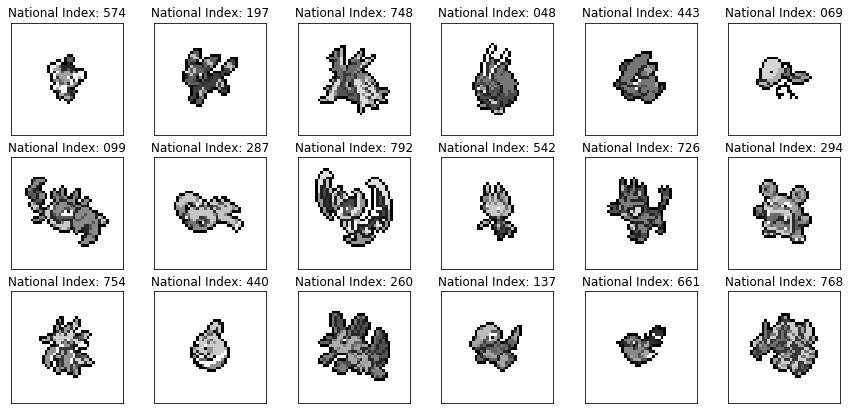

In [414]:
sample = np.random.choice(len(image_data), size=18, replace=False)
fig = plt.figure(figsize=(15, 7))
for i, img_index in enumerate(sample):
    ax = fig.add_subplot(3, 6, i + 1, xticks=[], yticks=[])
    if color:
        ax.imshow(image_data[img_index])
    else:
        ax.imshow(image_data[img_index], cmap='gray')
    ax.set_title(f"National Index: {filenames[img_index][:3]}")

### Datasets & DataLoaders

In [415]:
data = torch.from_numpy(image_data)

In [416]:
data.size(), data.dtype

(torch.Size([857, 40, 40]), torch.float32)

In [417]:
data.shape

torch.Size([857, 40, 40])

In [418]:
training_dataset = torch.utils.data.TensorDataset(data)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True)

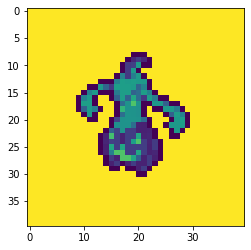

In [419]:
dataset_sample = next(iter(training_dataloader))[0][0]
plt.imshow(dataset_sample)

## Networks

In [430]:
img_size = 40

# Discriminator
d_in = img_size * img_size * (3 if color else 1)
d_hidden = [400]
d_out = 1

# Generator
noise_size = 50
g_hidden = [250, 1000]
g_out = d_in

dropout = 0.2

### Discriminator

In [431]:
D = discriminators.FCDiscriminator(d_in, d_hidden, d_out, dropout=dropout)
D

FCDiscriminator(
  (layers): ModuleList(
    (0): Linear(in_features=1600, out_features=400, bias=True)
  )
  (out): Linear(in_features=400, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
)

### Generator

In [432]:
G = generators.BasicFCGenerator(noise_size, g_hidden, g_out, dropout)
G

BasicFCGenerator(
  (layers): ModuleList(
    (0): Linear(in_features=50, out_features=250, bias=True)
    (1): Linear(in_features=250, out_features=1000, bias=True)
  )
  (out): Linear(in_features=1000, out_features=1600, bias=True)
  (dropout): Dropout(p=0.2)
)

### Losses

In [443]:
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    labels = torch.ones_like(D_out)
    labels = labels * 0.9 if smooth else labels 
    
    loss_criterion = nn.BCEWithLogitsLoss()
    loss = loss_criterion(D_out, labels)
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    labels = torch.zeros_like(D_out)
    
    loss_criterion = nn.BCEWithLogitsLoss()
    loss = loss_criterion(D_out, labels)
    return loss

### Optimisers

In [444]:
# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer = optim.Adam(G.parameters(), lr=lr)

## Training

In [ ]:
# training hyperparams
num_epochs = 60

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = utils.generate_random((sample_size, noise_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, real_images in enumerate(training_dataloader):
                
        real_images = real_images[0]
        batch_size = real_images.size(0)
        real_images = real_images * 2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
                
        # 1. Train with real images
        d_optimizer.zero_grad()
        
        # Compute the discriminator losses on real images
        # use smoothed labels
        batch_out_real = D.forward(real_images)
        d_real_loss = real_loss(batch_out_real, smooth=True)
        
        # 2. Train with fake images
        # Generate fake images
        z = utils.generate_random((batch_size, noise_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        
        # add up real and fake losses and perform backprop
        batch_out_fake = D.forward(fake_images)
        d_fake_loss = fake_loss(batch_out_fake)
    
        d_loss = d_fake_loss + d_real_loss
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        
        # 1. Train with fake images and flipped labels
        g_optimizer.zero_grad()
        
        # Generate fake images
        z = utils.generate_random((batch_size, noise_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        
        # perform backprop
        gen_out_fake = D(fake_images)
        g_loss = real_loss(gen_out_fake)
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   60] | d_loss: 1.4404 | g_loss: 0.8222
Epoch [    2/   60] | d_loss: 0.7570 | g_loss: 1.4255
Epoch [    3/   60] | d_loss: 0.4180 | g_loss: 4.1738
Epoch [    4/   60] | d_loss: 0.8536 | g_loss: 1.9241
Epoch [    5/   60] | d_loss: 1.7106 | g_loss: 1.2373
Epoch [    6/   60] | d_loss: 0.7967 | g_loss: 1.6325
Epoch [    7/   60] | d_loss: 1.0828 | g_loss: 0.9004
Epoch [    8/   60] | d_loss: 1.4926 | g_loss: 0.9022
Epoch [    9/   60] | d_loss: 0.9892 | g_loss: 0.8822
Epoch [   10/   60] | d_loss: 1.3099 | g_loss: 1.0606
Epoch [   11/   60] | d_loss: 1.4134 | g_loss: 0.5486
Epoch [   12/   60] | d_loss: 1.3242 | g_loss: 0.8555
Epoch [   13/   60] | d_loss: 1.3218 | g_loss: 0.7512
Epoch [   14/   60] | d_loss: 1.5481 | g_loss: 0.8144
Epoch [   15/   60] | d_loss: 1.3157 | g_loss: 0.6852
Epoch [   16/   60] | d_loss: 1.1257 | g_loss: 1.5264
Epoch [   17/   60] | d_loss: 0.8779 | g_loss: 1.3652
Epoch [   18/   60] | d_loss: 1.1392 | g_loss: 1.3308
Epoch [   19/   60] | d_loss

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

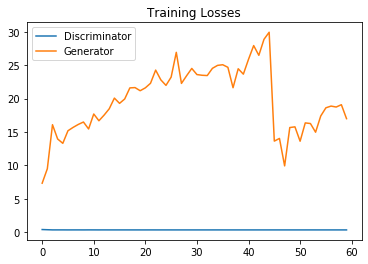

In [433]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Sampling

In [434]:
# randomly generated, new latent vectors
sample_size=16
rand_z = utils.generate_random((sample_size, noise_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
with torch.no_grad():
    rand_images = G(rand_z)

In [440]:
def reshape_sample(samples, img_size, is_rgb=True):
    samples = (samples + 1) / 2  # Reverse scaling
    if is_rgb:
        samples = samples.view(samples.size(0), img_size, img_size, 3)
    else:
        samples = samples.view(samples.size(0), img_size, img_size)
    samples.detach()
    return samples.numpy()

In [441]:
reshaped_images = reshape_sample(rand_images, img_size, is_rgb=color)

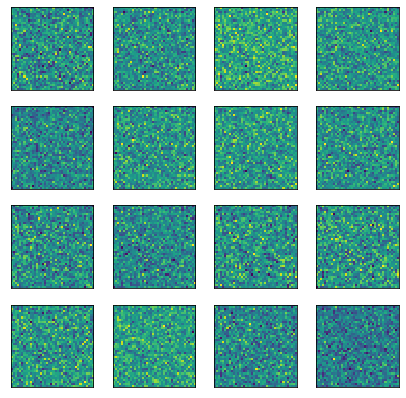

In [442]:
fig = plt.figure(figsize=(7, 7))
for i, s in enumerate(reshaped_images):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(s)